In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import matplotlib.pyplot as plt
import pathlib, os, random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Activation

In [5]:
epochs = 2
batch_size = 16
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale= 1.0 / 255)

train_ds = data_gen.flow_from_directory('/kaggle/input/processed-alzheimer-disease-adni-dataset/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/train/', 
                                        target_size=(img_height, img_width), class_mode='binary', batch_size=batch_size, subset='training')

val_ds = data_gen.flow_from_directory('/kaggle/input/processed-alzheimer-disease-adni-dataset/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/val/', 
                                      target_size=(img_height, img_width), class_mode='binary', batch_size=batch_size, shuffle=False)

Found 1323 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


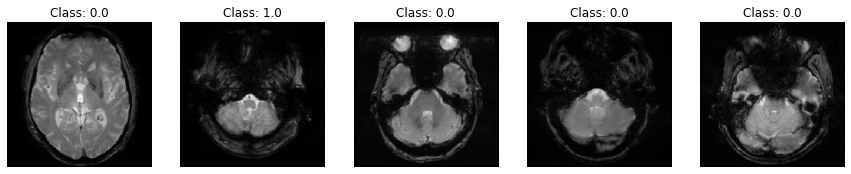

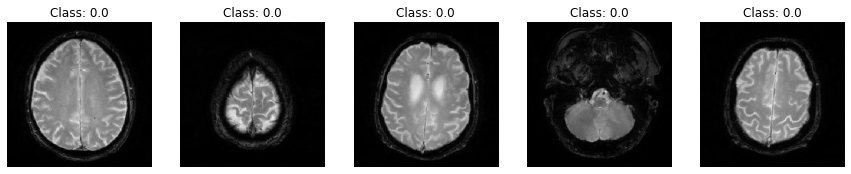

In [6]:
import matplotlib.pyplot as plt
def visualize_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {labels[i]}")
        plt.axis("off")
    plt.show()
visualize_images(train_ds, num_images=5)
visualize_images(val_ds, num_images=5)

In [13]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, input_shape=(224, 224, 3)):
        super(BaseModel, self).__init__()
        self.model_name = model_name
        
        self.conv1 = Conv2D(32, (3, 3), padding='same', input_shape=input_shape, name='conv1')
        self.batchnorm1 = BatchNormalization(name='batchnorm1')
        self.activation1 = Activation('relu', name='activation1')
        self.maxpool1 = MaxPooling2D(2, padding='same', name='maxpool1')

        self.conv2 = Conv2D(32, (3, 3), padding='same', name='conv2')
        self.batchnorm2 = BatchNormalization(name='batchnorm2')
        self.activation2 = Activation('relu', name='activation2')
        self.maxpool2 = MaxPooling2D(2, padding='same', name='maxpool2')
        self.dropout1 = Dropout(0.3, name='dropout1')

        self.conv3 = Conv2D(32, (3, 3), padding='same', name='conv3')
        self.batchnorm3 = BatchNormalization(name='batchnorm3')
        self.activation3 = Activation('relu', name='activation3')
        self.maxpool3 = MaxPooling2D(2, padding='same', name='maxpool3')
        self.dropout2 = Dropout(0.3, name='dropout2')

        self.flatten = Flatten(name='flatten')
        self.dense1 = Dense(64, activation='relu', name='dense1')
        self.batchnorm4 = BatchNormalization(name='batchnorm4')
        self.dense2 = Dense(64, activation='relu', name='dense2')
        self.dense3 = Dense(32, activation='relu', name='dense3')
        self.dense4 = Dense(32, activation='relu', name='dense4')
        self.output_layer = Dense(2, activation='softmax', name='output_layer')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.activation1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation2(x)
        x = self.maxpool2(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.activation3(x)
        x = self.maxpool3(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.batchnorm4(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.output_layer(x)
        
        return output
    
    def __repr__(self):
        return f"{self.model_name}_Model"
    
    
model = BaseModel(model_name='model6')

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './MyModel.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_best_only=True, save_weights_only=True)

history = model.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback])

model.summary()

file = open('./MyModelWeights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

Epoch 1/2
83/83 [==============================] - 56s 650ms/step - loss: 0.5699 - sparse_categorical_accuracy: 0.6841 - val_loss: 1.2346 - val_sparse_categorical_accuracy: 0.4146
Epoch 2/2
83/83 [==============================] - 53s 641ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.8239 - val_loss: 0.7896 - val_sparse_categorical_accuracy: 0.5671
Model: "base_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               multiple                  896       
_________________________________________________________________
batchnorm1 (BatchNormalizati multiple                  128       
_________________________________________________________________
activation1 (Activation)     multiple                  0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      multiple                  0         
________________________

In [14]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

In [ ]:
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(16, 8))
# plt.style.use("default")
# plt.subplot(1, 2, 1)
# plt.title('Training And Validation ACC')
# plt.plot(acc, label='Training')
# plt.plot(val_acc, label='Validation')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title('Training And Validation Loss')
# plt.plot(loss, label='Training')
# plt.plot(val_loss, label='Validation')

# plt.legend()

# plt.show()